In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from glob import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
import shutil
import random
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

2023-02-17 22:26:30.443000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train & Test split
#### split the data to 2 separate  dirs.

### ~ RUN THIS CELL CODE ONCE! ~

In [2]:
# set random seed for reproducibility
random.seed(42)

# define paths for dataset and train/test splits
data_path = "FMD_DATASET"
train_path = "train"
test_path = "test"

# create directories for train and test data
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# loop over each class in the dataset
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # create directories for train and test data for this class
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # get list of subdirectories for this class
    subdirectories = os.listdir(class_path)

    # loop over each subdirectory in the class
    for subdirectory_name in subdirectories:
        subdirectory_path = os.path.join(class_path, subdirectory_name)

        # create directories for train and test data for this subdirectory
        train_subdirectory_path = os.path.join(train_class_path, subdirectory_name)
        test_subdirectory_path = os.path.join(test_class_path, subdirectory_name)
        os.makedirs(train_subdirectory_path, exist_ok=True)
        os.makedirs(test_subdirectory_path, exist_ok=True)

        # get list of image filenames for this subdirectory
        images = os.listdir(subdirectory_path)

        # shuffle the list of images
        random.shuffle(images)

        # split the list of images into train and test sets
        split_index = int(len(images) * 0.8)  # 80% train, 20% test
        train_images = images[:split_index]
        test_images = images[split_index:]

        # move the train and test images to their respective directories
        for image in train_images:
            src = os.path.join(subdirectory_path, image)
            dst = os.path.join(train_subdirectory_path, image)
            shutil.copyfile(src, dst)

        for image in test_images:
            src = os.path.join(subdirectory_path, image)
            dst = os.path.join(test_subdirectory_path, image)
            shutil.copyfile(src, dst)

### load data with ImageDataGenerator

First we will use ImageDataGenerator a class in the Keras library for deep learning,
which is used to preprocess image data.
The flow_from_directory method is used to generate batches of image data from a directory
containing subdirectories of images,
with each subdirectory representing a class label.
The method takes the path to the directory containing the images as an argument.

In [3]:
#Scale the pixel values of the images from a range of [0, 255] to [0, 1].
#Use 80% of the images for training and 20% for validation
datagen_train = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)
datagen_test = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)

In [4]:
data_train = datagen_train.flow_from_directory(
    "train",
    target_size=(150, 150),
    batch_size=800,
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

data_test = datagen_test.flow_from_directory(
    "test",
    target_size=(150, 150),
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 11628 images belonging to 3 classes.
Found 2908 images belonging to 3 classes.


DATA DETAILS

In [5]:
counts_train = np.bincount(data_train.labels)
print("classes: ",data_train.class_indices,
      "\nimage shape: ", data_train.image_shape,
      "\n\ntrain: ",
      "\n  * class 'incorrect_mask' (0): ", counts_train[0],
      "\n  * class 'with_mask' (1): ", counts_train[1],
      "\n  * class 'without_mask' (2): ", counts_train[2],)

counts_test = np.bincount(data_test.labels)
print("\ntest:",
      "\n  * class 'incorrect_mask' (0): ", counts_test[0],
      "\n  * class 'with_mask' (1): ", counts_test[1],
      "\n  * class 'without_mask' (2): ", counts_test[2],)

classes:  {'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2} 
image shape:  (150, 150, 3) 

train:  
  * class 'incorrect_mask' (0):  4000 
  * class 'with_mask' (1):  3831 
  * class 'without_mask' (2):  3797

test: 
  * class 'incorrect_mask' (0):  1000 
  * class 'with_mask' (1):  958 
  * class 'without_mask' (2):  950


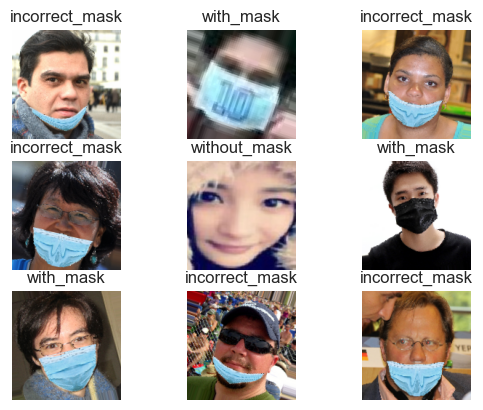

In [124]:
image_batch, labels_batch = data_train.next()

for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i])
      label = labels_batch[i]
      if np.array_equal(label, np.array([1., 0., 0.])):
            plt.title('incorrect_mask')
      elif np.array_equal(label, np.array([0., 1., 0.])):
            plt.title('with_mask')
      else:
            plt.title('without_mask')
      plt.axis("off")

## CNN model architecture
In this model architecture,
we have used 3 Convolutional layers followed by 3 MaxPooling layers,
a flatten layer to convert the 3D tensor into a 1D tensor, a Dropout layer to avoid overfitting,
and finally two Dense layers to classify the images into 3 classes.

In [ ]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(3, activation='softmax'))

### Compile the model
Here we have used 'categorical_crossentropy' as the loss function,
'adam' as the optimizer,
and 'accuracy' as the metric to evaluate the performance of the model.

In [ ]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

In [ ]:
history = model_cnn.fit(data_train, epochs=4)

### save the model - for future predict

In [ ]:
# Save the model
model_cnn.save('cnn_model.h5')

## plot the accuracy & loss during the train

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Acuuracy & Loss on Train and Test

In [ ]:
model_cnn_load = load_model('cnn_model.h5')

In [ ]:
# Evaluate the model on the train data
train_loss, train_acc = model_cnn_load.evaluate(data_test)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)

# Evaluate the model on the test data
test_loss, test_acc = model_cnn_load.evaluate(data_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# Get the number of samples in the test set
num_samples = len(data_test.filenames)

# Generate predictions for the entire test set
predictions = model_cnn_load.predict(data_test, steps=num_samples // data_test.batch_size)

# Convert predictions from probabilities to class labels
y_pred = predictions.argmax(1)

# Get the true labels for the test set
y_true = data_test.labels[:2880]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

In [ ]:
# Define the class labels
class_labels = list(data_test.class_indices.keys())

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', ax=ax)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## results

   * train: 93.1%
   * test: 93.0%

-->  the model learned the data well, and there is no overfitting!

in addition, the confusion matrix has good results too



## Machine Learning
  Now, we would like to run machine learning models and for this purpose we will create an encoder model that
  will encode each image into a vector and thus reduce the size of the images instead of a 150*150 vector we will
  get a 64 size vector!

In [72]:
encoder = models.Sequential()
encoder.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
encoder.add(layers.MaxPooling2D((2, 2)))
encoder.add(layers.Conv2D(64, (3, 3), activation='relu'))
encoder.add(layers.MaxPooling2D((2, 2)))
encoder.add(layers.Flatten())
encoder.add(layers.Dropout(0.5))
encoder.add(layers.Dense(64, activation='relu'))
encoder.add(layers.Dense(3, activation='softmax'))

encoder.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
### Train the model
history = encoder.fit(data_train, epochs=4)

Epoch 1/4
 5/15 [=========>....................] - ETA: 1:51 - loss: 2.5874 - accuracy: 0.3826

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 209s 13s/step - loss: 1.5909 - accuracy: 0.3820
Epoch 2/4
15/15 [==============================] - 211s 14s/step - loss: 0.6989 - accuracy: 0.7600
Epoch 3/4
15/15 [==============================] - 226s 15s/step - loss: 0.2992 - accuracy: 0.9008
Epoch 4/4
15/15 [==============================] - 225s 15s/step - loss: 0.2233 - accuracy: 0.9268


In [73]:
from keras.models import Model
# Extract features using the trained CNN model
encoder_vec = Model(inputs=encoder.input, outputs=encoder.layers[-2].output)

train_features = []
train_labels = []
for i in range(len(data_train)):
    batch = data_train[i]
    features = encoder_vec.predict(batch[0])
    train_features.append(features)
    train_labels.append(batch[1])
train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []
for i in range(len(data_test)):
    batch = data_test[i]
    features = encoder_vec.predict(batch[0])
    test_features.append(features)
    test_labels.append(batch[1])
test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

25/25 [==============================] - 2s 94ms/step


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


In [80]:
train_features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.4455709 ,
        1.7093385 ],
       [0.        , 0.        , 0.        , ..., 0.        , 2.085069  ,
        0.        ],
       [0.7019175 , 0.        , 0.        , ..., 0.        , 1.6767751 ,
        0.        ],
       ...,
       [2.0081306 , 0.        , 0.        , ..., 0.        , 5.6005907 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03595272,
        0.83012545],
       [0.        , 0.        , 0.        , ..., 0.        , 6.2667413 ,
        0.        ]], dtype=float32)

In [81]:
# Instead of train_labels[0] = [1,0,0] -> train_labels[0] = 0
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [82]:
print("train shape: ", train_features.shape ,"\n",
      "train labels shape: ", train_labels.shape, "\n",
      "test shape: ", test_features.shape, "\n",
      "test labels shape: " ,test_labels.shape)

train shape:  (11628, 64) 
 train labels shape:  (11628,) 
 test shape:  (2908, 64) 
 test labels shape:  (2908,)


In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#this function get the model and print the Accuracy and the Confusion Matrix
def printAcc(model):
    model.fit(train_features, train_labels)
    train_acc = model.score(train_features, train_labels)
    test_acc = model.score(test_features, test_labels)

    print("Train accuracy of ",model," model: " ,train_acc)
    print("Test accuracy of ",model," model: ", test_acc)

    # Calculate the confusion matrix for the test set
    y_pred = model.predict(test_features)
    cm = confusion_matrix(test_labels, y_pred)

    # Plot the confusion matrix using seaborn's heatmap
    sns.heatmap(cm, annot=True,fmt='.0f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion matrix for '+str(model)+' model')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


# Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy of  LogisticRegression(multi_class='multinomial')  model:  0.9385104919160647
Test accuracy of  LogisticRegression(multi_class='multinomial')  model:  0.9422283356258597


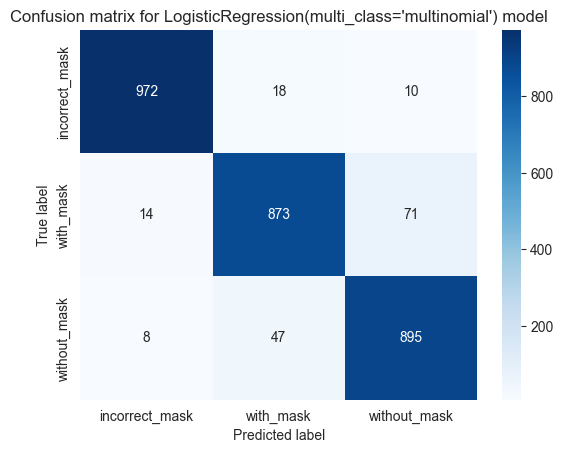

In [84]:
from sklearn.linear_model import LogisticRegression

# Train a machine learning model on the extracted features
lOGclf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
printAcc(lOGclf)


# Random Forest

Train accuracy of  RandomForestClassifier()  model:  1.0
Test accuracy of  RandomForestClassifier()  model:  0.9436038514442916


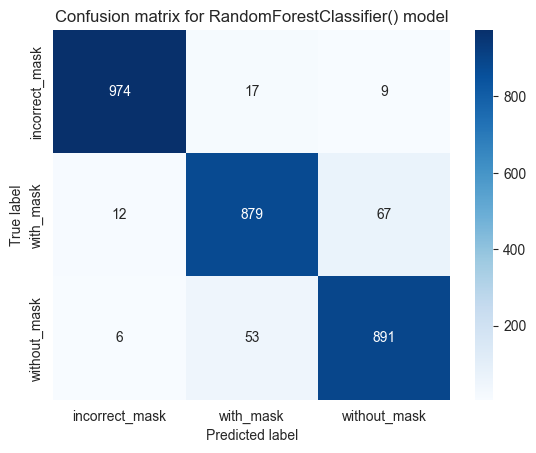

In [85]:
from sklearn.ensemble import RandomForestClassifier
RANDclf = RandomForestClassifier()
printAcc(RANDclf)

# KNN nearest neighborhood

Train accuracy of  KNeighborsClassifier()  model:  0.9507223942208463
Test accuracy of  KNeighborsClassifier()  model:  0.9411966987620357


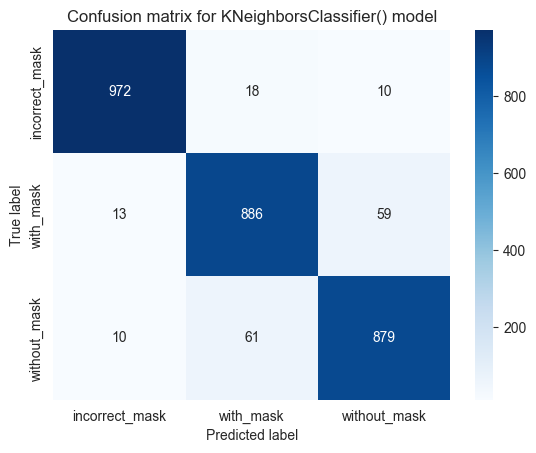

In [86]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN model on the extracted features
knn = KNeighborsClassifier(n_neighbors=5)
printAcc(knn)

Train accuracy of  SVC(C=1, kernel='linear')  model:  0.9434984520123839
Test accuracy of  SVC(C=1, kernel='linear')  model:  0.9449793672627235


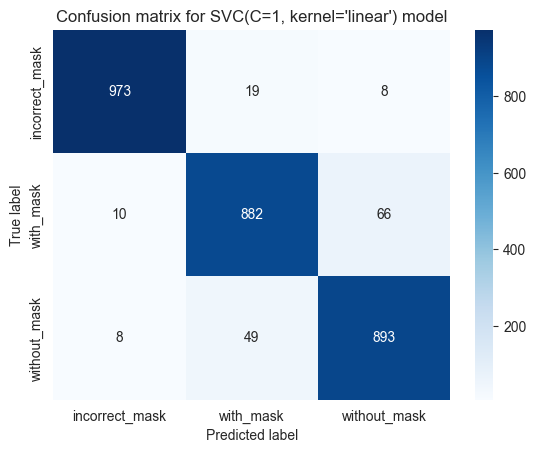

In [87]:
from sklearn import svm

# Train an SVM model on the extracted features
svm_model = svm.SVC(kernel='linear', C=1, gamma='scale')
printAcc(svm_model)

Train accuracy of  DecisionTreeClassifier()  model:  1.0
Test accuracy of  DecisionTreeClassifier()  model:  0.9164374140302614


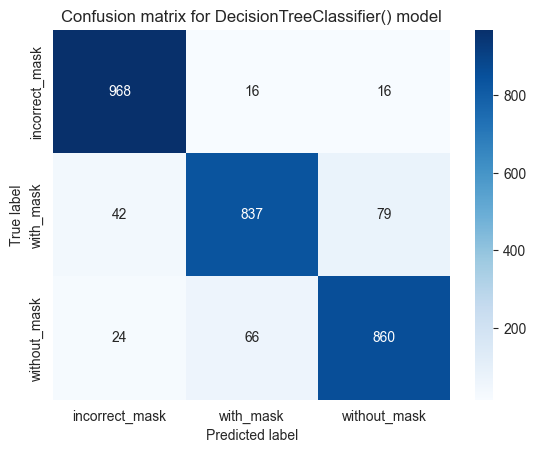

In [88]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree model on the extracted features
tree = DecisionTreeClassifier()
printAcc(tree)


We can see for DecisionTreeClassifier and RandomForestClassifier accuracy of 100% on the train data, this is
not overfitting because we get high accuracy for the test data. This is due to the extensive
training of the encoder, we created a deep learning model with layers and trained it until it got the best
weights on the train data, we took the one penultimate layer (before activation) and placed it as the new
vectors that represent the image, so it makes sense that strong models As these will be able to predict the
train with 100 percent accuracy

## PCA

In [110]:
x_train = []
y_train = []
for i in range(14):
    x_batch, y_batch = next(data_train)
    x_train.append(x_batch)
    y_train.append(y_batch)
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

reduce_data = x_train.reshape(x_train.shape[0], -1)
pca = PCA()
pca.fit(reduce_data)
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
k = np.argmax(var_cumu>95)
print("max k for 95%: ", k)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


max k for 95%:  587


In [111]:
x_test = []
y_test = []
for i in range(90):
    x_batch, y_batch = next(data_test)
    x_test.append(x_batch)
    y_test.append(y_batch)
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [112]:
# Instead of y_trains[0] = [1,0,0] -> y_train[0] = 0
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [113]:
print("train shape: ", x_train.shape ,"\n",
      "train labels shape: ", y_train.shape, "\n",
      "test shape: ", x_test.shape, "\n",
      "test labels shape: " ,y_test.shape)

train shape:  (10828, 150, 150, 3) 
 train labels shape:  (10828,) 
 test shape:  (2880, 150, 150, 3) 
 test labels shape:  (2880,)


In [114]:
# Fit PCA to training data
pca = PCA(n_components=k)
pca.fit(reduce_data)

# Transform training and testing data using PCA
x_train_pca = pca.transform(reduce_data)
x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], -1))

In [115]:
print(x_train_pca.shape)
print(x_test_pca.shape)

(10828, 587)
(2880, 587)


In [123]:

# Train and evaluate RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train_pca, y_train)
train_acc = rf.score(x_train_pca, y_train)
score = rf.score(x_test_pca, y_test)
print("Train accuracy:", train_acc )
print("Test accuracy:", score)

Train accuracy: 1.0
Test accuracy: 0.8260416666666667


In [117]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2', max_iter=1000, random_state=42)
sgd.fit(x_train_pca, y_train)
train_acc = rf.score(x_train_pca, y_train)
score = sgd.score(x_test_pca, y_test)
print("Train accuracy:", train_acc )
print("Test accuracy:", score)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Train accuracy: 1.0
Test accuracy: 0.8829861111111111
